## Dacon 캠프 오프라인 프로젝트
- 'SK Data Analyst 와 함께하는 데이터 사이언스 입문 교육 & 프로젝트' 에서 진행한 프로젝트입니다.
 - 교육에 대한, 자세한 내용은 링크 참고하세요, https://festa.io/events/443

## 프로젝트 목적
- train_final.csv 에는 과거의 1월 부터 5월 8일까지 로그인한 기록이 아래와 같이 남아 있다.
- 5월 9일 부터 일주일간, 로그인할 확률을 예측한다.

 - person_id: 유저별 고유 아이디
 - Sex: 성별
 - past_login_total: 과거에 로그인한 총 횟수
 - past_1_month_login: 과거1달간 로그인한 총 횟수, 4월8일부터 5월8일까지 로그인 회수
 - past_1_week_login: 과거 1주간 로그인한 총 횟수, 5월1일부터 5월8일까지 로그인 회수
 - sub_size: 과거에 데이콘 대회에서의 총 제출 수
 - email_type: 가입한 이메일 종류
 - phone_rat: 폰으로 접속한 비율
 - apple_rat: 애플 기기(아이폰과 맥북)으로 접속한 비율
 - login : 로그인 여부 

## 프로젝트 목표
- 여러가지 classifer를 사용할 예정이고, 각 classifer에서 모두 성능이 향상되는, feature engineering 하는 것을 목표로 한다.

## 1. 사용할 라이브러리 및 데이터 불러오기

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# train_final.csv test_final.csv 파일은 dacon에서 프로젝트 진행용도로만 
# 교육 참여자에게 배포한 파일이라서, 포함되어 있지 않습니다.
train_data = pd.read_csv('../../project_data_files_from_dacon/train_final.csv') # tain data
test_data = pd.read_csv('../../project_data_files_from_dacon/test_final.csv') # test 로그인 예측할 data

train_df = train_data.copy()
test_df = test_data.copy()

In [124]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
person_id             1500 non-null int64
Sex                   1186 non-null object
email_type            1500 non-null object
past_1_month_login    1340 non-null float64
past_1_week_login     1340 non-null float64
past_login_total      1340 non-null float64
phone_rat             1500 non-null float64
apple_rat             1500 non-null float64
sub_size              1500 non-null float64
login                 1500 non-null int64
dtypes: float64(6), int64(2), object(2)
memory usage: 117.3+ KB


In [125]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 9 columns):
person_id             682 non-null int64
Sex                   545 non-null object
email_type            682 non-null object
past_1_month_login    615 non-null float64
past_1_week_login     615 non-null float64
past_login_total      615 non-null float64
phone_rat             682 non-null float64
apple_rat             682 non-null float64
sub_size              682 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 48.0+ KB


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing

### NaN인 컬럼이 있는지 확인

Index(['person_id', 'Sex', 'email_type', 'past_1_month_login',
       'past_1_week_login', 'past_login_total', 'phone_rat', 'apple_rat',
       'sub_size', 'login'],
      dtype='object')
Index(['person_id', 'Sex', 'email_type', 'past_1_month_login',
       'past_1_week_login', 'past_login_total', 'phone_rat', 'apple_rat',
       'sub_size'],
      dtype='object')


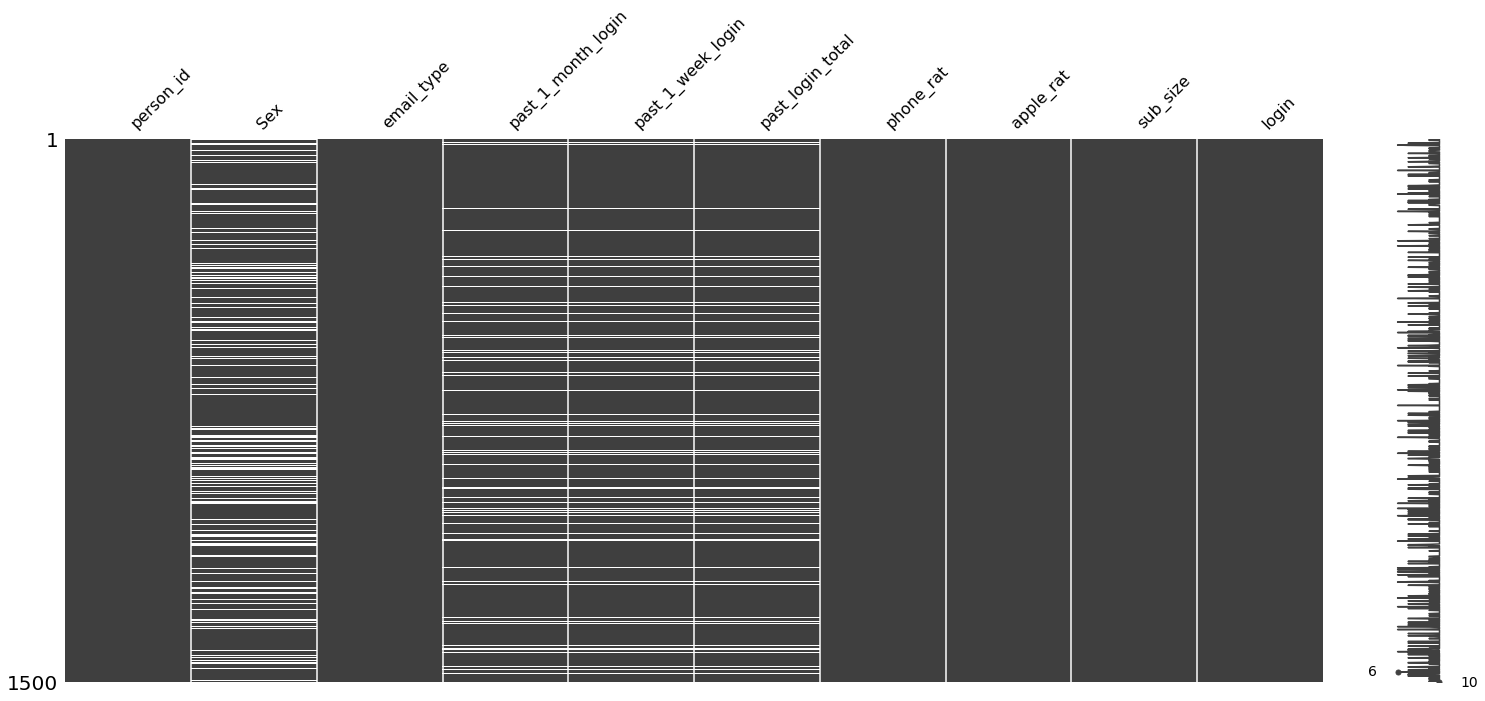

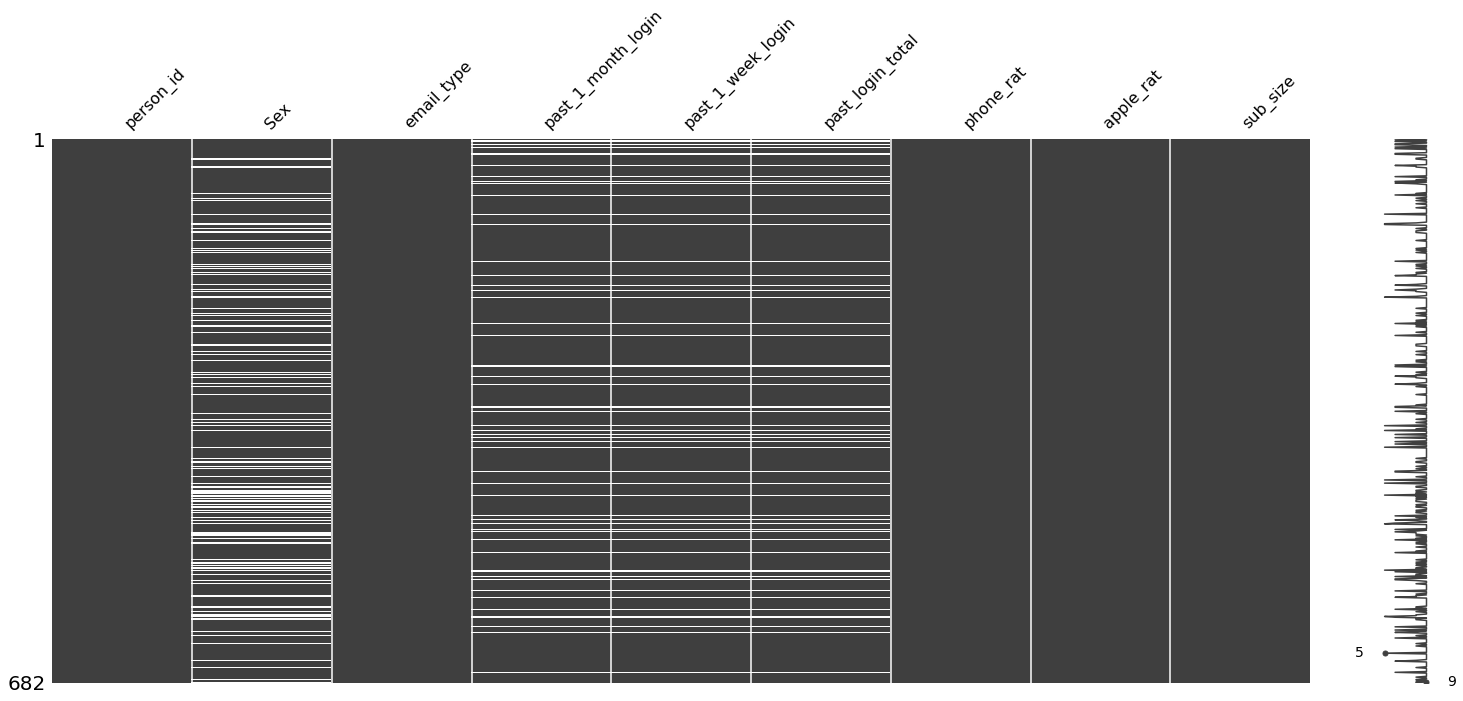

In [126]:
# 차트가 클때, 스크롤 없이 차트 전체를 cell 에서 보이게 하기
# Cell -> All Output -> Toggle Scrolling
print(train_df.columns)
msno.matrix(train_df)
print(test_df.columns)
msno.matrix(test_df)

- TODO Sex missing 데이터 있음
- TODO missing 데이터 있는 컬럼 'past_1_month_login', 'past_1_week_login', 'past_login_total'

### Sex 컬럼의 missing 데이터 크기 확인
- Unknown으로 되어 있는 row숫자도 400이 넘을 정도로 많기 때문에, Missing을 Unknown으로 변경 하기로 함

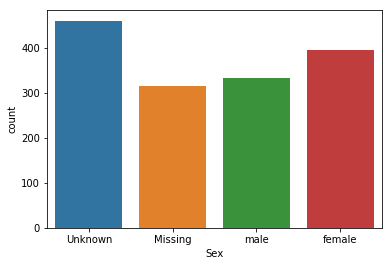

In [127]:
# NAN은 sns.countplot()에서 포함 되지 않아서,
# 임시로, NaN을 Missing으로 변경해서, 차트에 포함 시킴
sns.countplot(x = train_df.Sex.fillna('Missing'), data = train_df)

### 로그인 한 수/로그인 안한 수 비교
- train 데이터가 로그인 안한 쪽이 10배 이상 많음

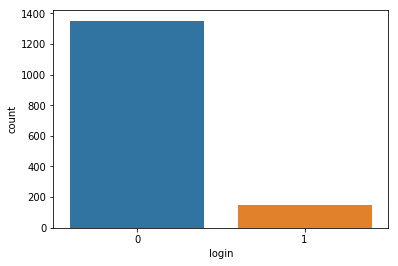

In [128]:
sns.countplot(x = train_df.login, data = train_df)

### Sex/email_type과 login 여부 비교
- Sex에 따른 login 여부는 그렇게 크지 않음
- email_type에 따른 login 여부 차이가 커서, EDA필요함

Column :  Sex


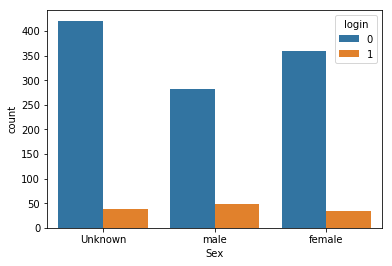

Column :  email_type


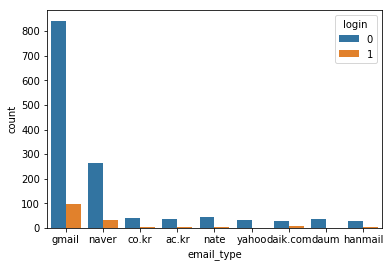

In [129]:
for col in train_df.columns:
    if col in ['Sex', 'email_type']:
        print('Column : ', col)
        sns.countplot(x = col, hue = 'login', data= train_df)
        plt.show()

### email_type 별로 login 여부 비율
- gmail과 naver가 0.1 정도로 높게 나옴
- email_type별로, 로그인한 비율이 차이를 보임, 삭제하지 않고, 남겨둠

In [130]:
def email_type_login_rate(df):
    for email_type in df.email_type.unique():
        a = df[df['email_type'] == email_type].loc[:, 'login'].sum()
        
        b = df[df['email_type'] == email_type].loc[:, 'login'].count()
        print(email_type + ' rate ' + str(a/b) + ' count ' + str(a)+'/'+str(b))
        
email_type_login_rate(train_df)

gmail rate 0.1023454157782516 count 96/938
naver rate 0.10774410774410774 count 32/297
co.kr rate 0.10638297872340426 count 5/47
ac.kr rate 0.05263157894736842 count 2/38
nate rate 0.0425531914893617 count 2/47
yahoo rate 0.0 count 0/33
daik.com rate 0.1875 count 6/32
daum rate 0.027777777777777776 count 1/36
hanmail rate 0.15625 count 5/32


### train_df와 test_df가 email_type에 따라서, 각 컬럼이 비슷한 분포를 보이는지 확인함
- train_df와 test_df가 email_type에 따라서, 비슷한 분포를 보임
- email_type을 삭제하지 않고, 남겨두기로 결정 (처음에는 필요 없는 컬럼이라고 생각해서, 삭제하려고 했었음)

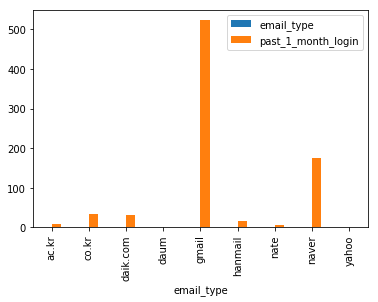

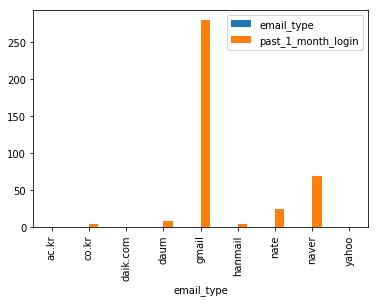

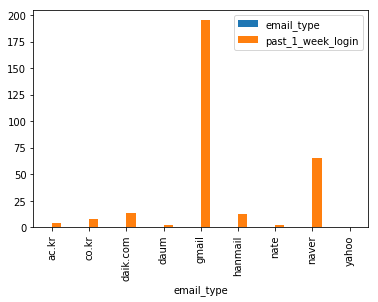

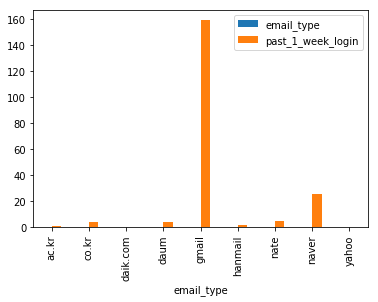

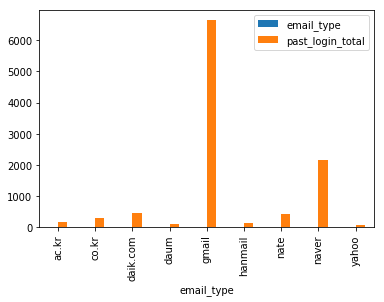

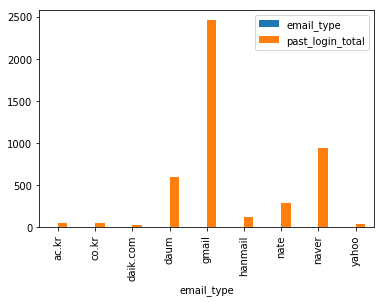

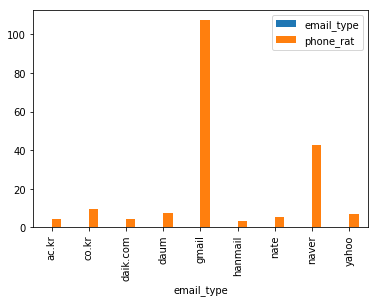

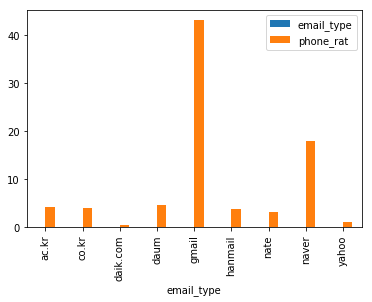

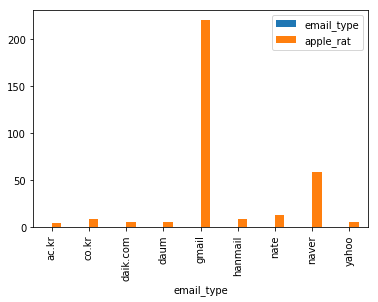

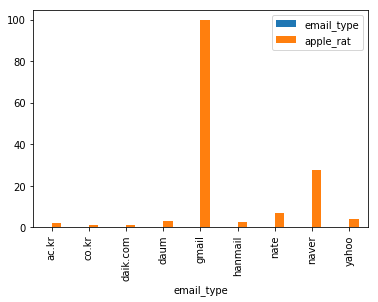

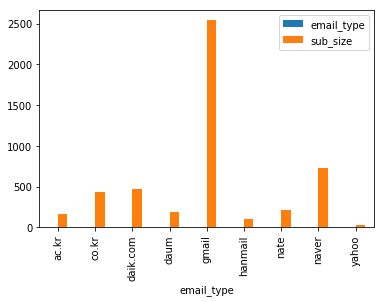

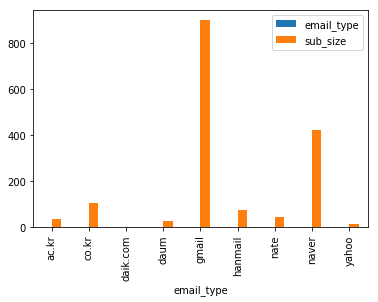

In [131]:
def email_type_vs_other_column_sum_graph(df, df2):
    df = df.copy()
    del df['login']
    mydf = df.groupby('email_type').sum()
    mydf.head()
    
    mydf2 = df2.groupby('email_type').sum()
    mydf2.head()

    for col in mydf.columns:
        if col not in ['email_type', 'person_id']:
            #print('Column : ', col)
            mydf.loc[:,['email_type', col]].plot.bar()
            mydf2.loc[:,['email_type', col]].plot.bar()
            #print('-'*80)
            #plt.show()

email_type_vs_other_column_sum_graph(train_df, test_df)

### 데이터 클리닝 함수
- person_id는 사용자를 구별하는 숫자로, 로그인 횟수와 관계 없음, 학습/추론 할 데이터에서 삭제함
 - 마지막에 dacon.io에 제출할 데이터를 만들 때 필요함으로 카피한다
- Sex에 NA는 Unknown으로 변경함
- apple_rat는 mac과 iphone 모두를 포함한 비율이라서, 필요가 없음
- train_df에서 login은 복사해 두고 삭제함

In [132]:
train_person_id = train_df['person_id'].copy()
test_person_id = test_df['person_id'].copy()

def clean_data(df):
    del df['person_id']
    df['Sex'].fillna('Unknown', inplace =True)
    df['Sex'].replace('Missing', 'Unknown', inplace =True)
    
    # apple_rat 는 mac과 iphone을 모두 포함한 비율이라서, 필요가 없음
    del df['apple_rat']
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

### 전처리 함수
- desktop과 phone은 서로 로그인 한 목적이 다름, phone은 로그인 한 뒤에 확인 이외에 할수 있는 작업이 desktop보다 제한 적임
- 1 - phone_rat을 해서, desktop_rat를 만들어 냄
- 컬럼의 순서를 변경해서, 관련 있는 컬럼끼리 옆에 있도록함

In [133]:
def pre_process(df):
    # 1 - phone_rat해서 desktop에서 로그인한 비율을 만들어냄
    df['desktop_rat'] = 1 - df['phone_rat']
    
    cols = ['Sex', 'email_type', 'past_login_total', 'past_1_month_login', 'past_1_week_login', 'login', 'phone_rat', 'desktop_rat', 'sub_size']
    df = df.loc[:, cols]
    
    return df
 
train_df = pre_process(train_df)
test_df = pre_process(test_df)

train_login = train_df['login'].copy()
del train_df['login']
del test_df['login']

## 3. 탐색적 자료분석
## Exploratory Data Analysis


### NaN인 컬럼 확인
- 아래 3개의 컬럼에 NaN 이 있음
- 다른 컬럼들을 사용해서 학습시킨 후에, 3개의 컬럼 값을 예측해서 NaN에서 복구 하기로 함

Index(['Sex', 'email_type', 'past_login_total', 'past_1_month_login',
       'past_1_week_login', 'phone_rat', 'desktop_rat', 'sub_size'],
      dtype='object')
Index(['Sex', 'email_type', 'past_login_total', 'past_1_month_login',
       'past_1_week_login', 'phone_rat', 'desktop_rat', 'sub_size'],
      dtype='object')


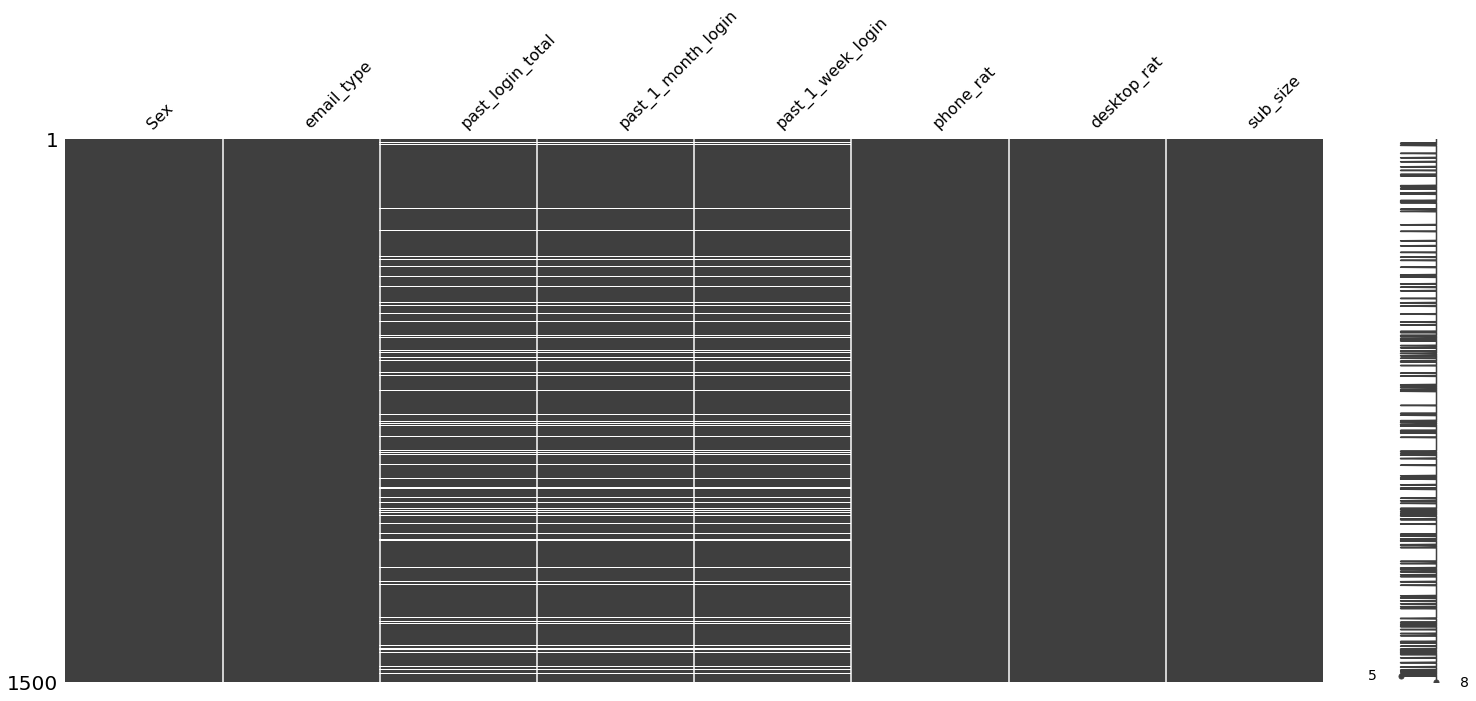

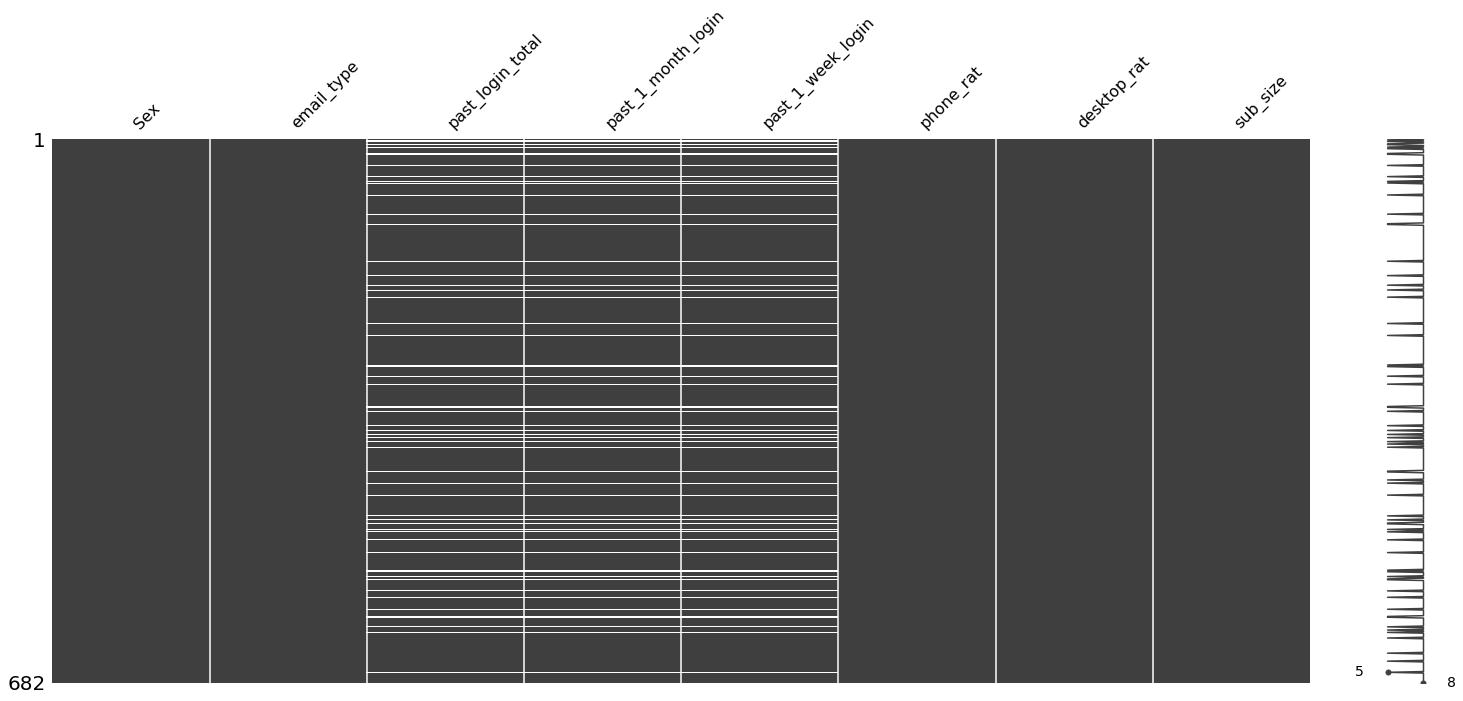

In [134]:
print(train_df.columns)
msno.matrix(train_df)
print(test_df.columns)
msno.matrix(test_df)

- 3개의 컬럼에서만 NaN 이 있고, 다른 컬럼에는 없음

In [135]:
def check_NaN_column(df):
    for col in df.columns:
        s = df[col].isna().sum()
        if s > 0:
            print(col + ' has NaN row')

print('train_df')
check_NaN_column(train_df)
print('test_df')
check_NaN_column(test_df)

train_df
past_login_total has NaN row
past_1_month_login has NaN row
past_1_week_login has NaN row
test_df
past_login_total has NaN row
past_1_month_login has NaN row
past_1_week_login has NaN row


- msno.matrix()차트에서 보기에는, NaN 값이 있는 row가 있을 때, 3개의 컬럼 모두 NaN인 것처럼 보임
- NaN컬럼에 대한 가설을 세워보자!
- train_df(or test_df)에 있는 row는 아래 3개의 컬럼 모두 NaN이거나, 3개의 컬럼 모두 NaN이 아니다.
 - past_login_total
 - past_1_month_login
 - past_1_week_login
 
- 가설 검증 방법
 - a, b, b 3개의 컬럼이 있음
 - a 와 b 컬럼이 항상 같은 row에 NaN값이 있는지 확인 -> ab
 - a 와 c 컬럼이 항상 같은 row에 NaN값이 있는지 확인 -> ac
 - ab와 ac가 같은지 확인
  - ab와 ac가 같은 row 길이가, 데이터 프레임의 길이와 같은가?
   - 같으면, 3개의 컬럼 모두 NaN이거나, 3개의 컬럼 모두 NaN이 아니다.
   - 다르면, 가설이 거짓임

In [136]:
def check_NaN_is_in_same_row(df):
    a = df['past_1_month_login'].isna()
    b = df['past_1_week_login'].isna()
    c = df['past_login_total'].isna()

    ab = (a == b)
    ac = (a == c)

    r = ((ab == ac)).sum()
    if r == len(df):
        return True
    else:
        return False
    
r = check_NaN_is_in_same_row(train_df)
print(r)
r = check_NaN_is_in_same_row(test_df)
print(r)

True
True


### NaN인 컬럼의 예측을 위한 학습데이터 만들기
- train_df와 test_df를 합치고, NaN이 아닌 row들만 모아서, 학습데이터 만든다

In [137]:
df = train_df.append(test_df)
nas = df['past_1_month_login'].isna()
not_missing_df = df[~nas]
print(not_missing_df.count())

Sex                   1955
email_type            1955
past_login_total      1955
past_1_month_login    1955
past_1_week_login     1955
phone_rat             1955
desktop_rat           1955
sub_size              1955
dtype: int64


### 5개의 classifier를 비교하여, 높은 성능이 나오는 것을 NA컬럼 복원에 사용하기로 함
- 1955 row 중에서, 7:3의 비율로 학습/검증 데이터셋으로 나눔
- 학습된 score, MSE 2가지 값을 그래프로 표시
- MSE가 가장 작은 classifier를 선택함

past_login_total
Index(['phone_rat', 'desktop_rat', 'sub_size', 'Sex_Unknown', 'Sex_female',
       'Sex_male', 'email_type_ac.kr', 'email_type_co.kr',
       'email_type_daik.com', 'email_type_daum', 'email_type_gmail',
       'email_type_hanmail', 'email_type_nate', 'email_type_naver',
       'email_type_yahoo'],
      dtype='object')
rf_score 0.6630116959064327
MSE 583.0647359454855
lbr_score 0.47368421052631576
MSE 670.4054514480409
xgb_score 0.6213450292397661
MSE 497.5519591141397
lgbm_score 0.668859649122807
MSE 567.8517887563884
gb_score 0.547514619883041
MSE 509.4003407155026


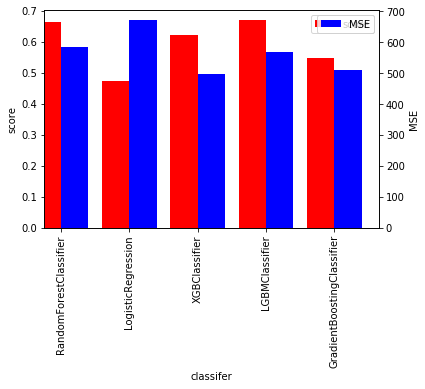

past_1_month_login
Index(['phone_rat', 'desktop_rat', 'sub_size', 'Sex_Unknown', 'Sex_female',
       'Sex_male', 'email_type_ac.kr', 'email_type_co.kr',
       'email_type_daik.com', 'email_type_daum', 'email_type_gmail',
       'email_type_hanmail', 'email_type_nate', 'email_type_naver',
       'email_type_yahoo'],
      dtype='object')
rf_score 0.8698830409356725
MSE 2.6013628620102214
lbr_score 0.8304093567251462
MSE 2.6303236797274274
xgb_score 0.841374269005848
MSE 2.6320272572402046
lgbm_score 0.8698830409356725
MSE 2.6320272572402046
gb_score 0.8706140350877193
MSE 20.45144804088586


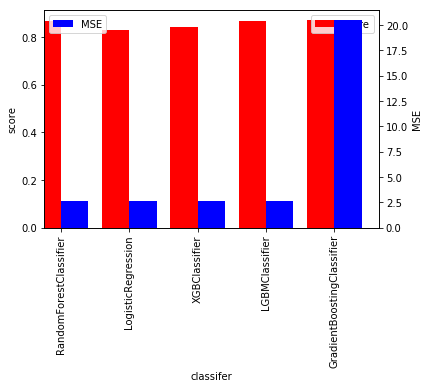

past_1_week_login
Index(['phone_rat', 'desktop_rat', 'sub_size', 'Sex_Unknown', 'Sex_female',
       'Sex_male', 'email_type_ac.kr', 'email_type_co.kr',
       'email_type_daik.com', 'email_type_daum', 'email_type_gmail',
       'email_type_hanmail', 'email_type_nate', 'email_type_naver',
       'email_type_yahoo'],
      dtype='object')
rf_score 0.9239766081871345
MSE 1.485519591141397
lbr_score 0.9013157894736842
MSE 1.2947189097103917
xgb_score 0.9057017543859649
MSE 1.2793867120954003
lgbm_score 0.9261695906432749
MSE 1.3969335604770017
gb_score 0.9298245614035088
MSE 2.34412265758092


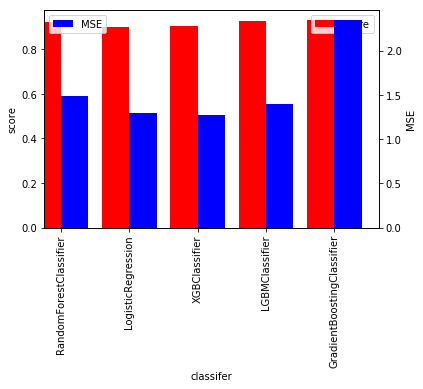

{'past_login_total': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 'past_1_month_login': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=2019,
                       verbose=0, warm_start=F

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

def train_to_recover_na_column(col, df):
    mydict = dict()
    mydict['classifer'] = []
    mydict['score'] = []
    mydict['MSE'] = []
    
    model = dict()
    
    print(col)
    df = pd.get_dummies(df)
    #print(df.head())
    
    df_y = df[col]
    
    del df['past_login_total']
    del df['past_1_month_login']
    del df['past_1_week_login']
    print(df.columns)
    x_train, x_traintest, y_train, y_traintest = train_test_split(df,
                                                                  df_y,
                                                                  test_size = 0.3,
                                                                  random_state=2019)
    
    mydict['classifer'].append('RandomForestClassifier')
    rf = RandomForestClassifier(random_state=2019)
    rf.fit(x_train, y_train)
    score = rf.score(x_train, y_train)
    print('rf_score', score)
    mydict['score'].append(score)
    y_pred = rf.predict(x_traintest)
    mse = mean_squared_error(y_traintest, y_pred)
    print('MSE {}'.format(mse))
    mydict['MSE'].append(mse)
    model[mse] = rf
    
    mydict['classifer'].append('LogisticRegression')
    lgr = LogisticRegression(random_state=2019)
    lgr.fit(x_train, y_train)
    score = lgr.score(x_train, y_train)
    print('lbr_score', score)
    mydict['score'].append(score)
    y_pred = lgr.predict(x_traintest)
    mse = mean_squared_error(y_traintest, y_pred)
    print('MSE {}'.format(mse))
    mydict['MSE'].append(mse)
    model[mse] = lgr

    mydict['classifer'].append('XGBClassifier')
    xgb = XGBClassifier(random_state=2019)
    xgb.fit(x_train, y_train)
    score = xgb.score(x_train, y_train)
    print('xgb_score', score)
    mydict['score'].append(score)
    y_pred = xgb.predict(x_traintest)
    mse = mean_squared_error(y_traintest, y_pred)
    print('MSE {}'.format(mse))
    mydict['MSE'].append(mse)
    model[mse] = xgb
    
    mydict['classifer'].append('LGBMClassifier')
    lgbm = LGBMClassifier(random_state=2019)
    lgbm.fit(x_train, y_train)
    score = lgbm.score(x_train, y_train)
    print('lgbm_score', score)
    mydict['score'].append(score)
    y_pred = lgbm.predict(x_traintest)
    mse = mean_squared_error(y_traintest, y_pred)
    print('MSE {}'.format(mse))
    mydict['MSE'].append(mse)
    model[mse] = lgbm
    
    mydict['classifer'].append('GradientBoostingClassifier')
    gb = GradientBoostingClassifier(random_state=2019)
    gb.fit(x_train, y_train)
    score = gb.score(x_train, y_train)
    print('gb_score', score)
    mydict['score'].append(score)
    y_pred = gb.predict(x_traintest)
    mse = mean_squared_error(y_traintest, y_pred)
    print('MSE {}'.format(mse))
    mydict['MSE'].append(mse)
    model[mse] = gb
    
    model = sorted(model.items())
    #print(model)
    #print()
    #lowest_mse = model.keys()[0]
    #print(model[lowest_mse])
    
    df = pd.DataFrame(mydict)
    return df, model[0][1]
   
def draw_score_MSE(df):
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    width = 0.4

    df.plot(x = 'classifer', y = 'score', kind='bar', color='red', ax=ax, width=width, position=1)
    df.plot(x = 'classifer', y = 'MSE', kind='bar', color='blue', ax=ax2, width=width, position=0)

    ax.set_ylabel('score')
    ax2.set_ylabel('MSE')

    plt.show()

cols = ['past_login_total', 'past_1_month_login', 'past_1_week_login']
#cols = ['past_login_total']

models = dict()

for col in cols:
    df, model = train_to_recover_na_column(col, not_missing_df)
    models[col] = model
    draw_score_MSE(df)
    print('=' * 80)

print(models)

### 학습시킨 classifer를 사용해서, NA column 복구 하기

In [139]:
#sm_x_train = pd.DataFrame(sm_x_train, columns = pd.get_dummies(train_df).columns)
not_missing_df

columns = ['phone_rat', 'desktop_rat', 'sub_size', 'Sex_Unknown', 'Sex_female',
       'Sex_male', 'email_type_ac.kr', 'email_type_co.kr',
       'email_type_daik.com', 'email_type_daum', 'email_type_gmail',
       'email_type_hanmail', 'email_type_nate', 'email_type_naver',
       'email_type_yahoo']

def recover_na_column(df, clss, columns):
    df = df.copy()
    tmp_df = pd.get_dummies(df)
    
    for i in tmp_df.index:
        row = tmp_df.loc[i,:]

        if np.isnan(row['past_login_total']):
            #print(i)
            del row['past_login_total']
            del row['past_1_month_login']
            del row['past_1_week_login']

            # 1d array를 길이 1의 2d arrary로 변경함
            row = np.array(row).reshape(1, -1)
            row_df = pd.DataFrame(row, columns = columns)
            #print(test)
            

            # 3개의 NA 컬럼 복구함
            cols = ['past_login_total', 'past_1_month_login', 'past_1_week_login']
            for col in cols:
                df.loc[i, col] = clss[col].predict(row_df)
    return df

train_recover_NaN_df = recover_na_column(train_df, models, columns)
test_recover_NaN_df = recover_na_column(test_df, models, columns)

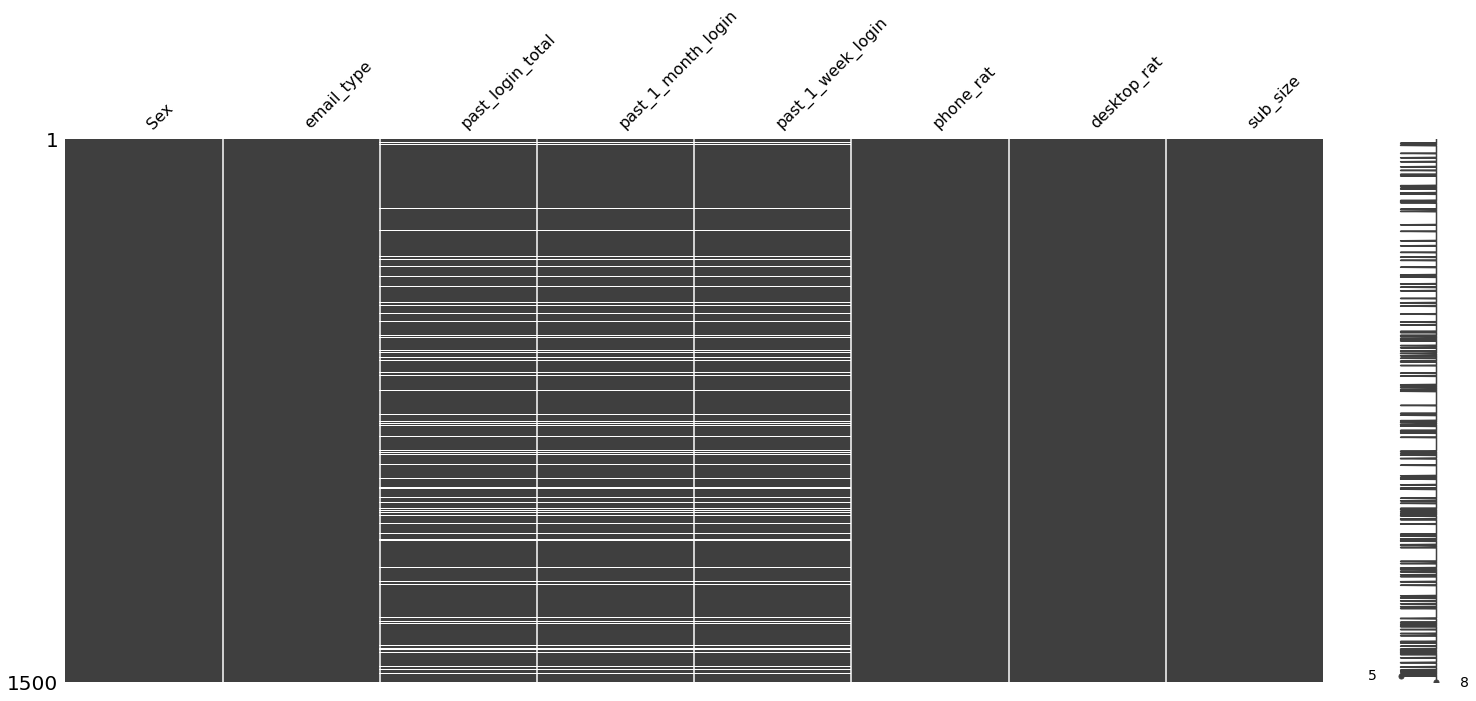

In [140]:
msno.matrix(train_df)

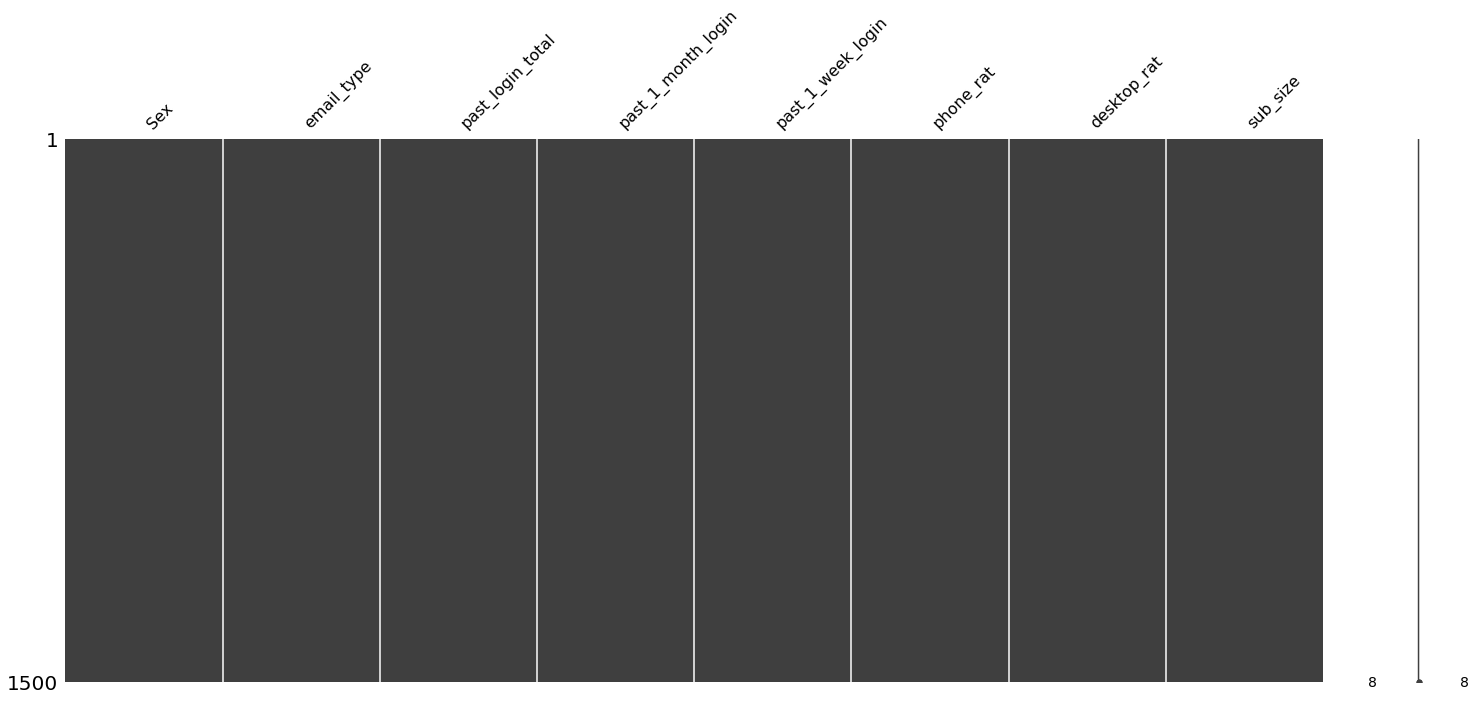

In [141]:
msno.matrix(train_recover_NaN_df)

## 4. 변수 선택 및 모델 구축
### NA column을 복구한 것과, NA column을 0으로 채운 것 2가지 데이터 프레임을 가지고, 마지막에 결과 비교할 예정

## Feature Engineering #1
### 최근에 로그인 한 사람일 수록, 앞으로 일주일 동안 로그인 할 확률이 높다
- 전체 로그인 회수 대비, 최근 일주일 동안 로그인한 비율을 새로운 컬럼으로 만듬
- 첫번째 feature engineering의미로 데이터프레임 변수 이름에 f1 붙임

In [72]:
def f1_recent_1_week_login_rate(df):
    df = df.copy()
    df['recent_1_week_login_rate'] = df['past_1_week_login'] / (df['past_login_total'] + df['past_1_month_login'])
    df = df.fillna(0)
    return df
    
train_f1_df = f1_recent_1_week_login_rate(train_df)
test_f1_df = f1_recent_1_week_login_rate(test_df)

train_f1_recover_NaN_df = f1_recent_1_week_login_rate(train_recover_NaN_df)
test_f1_recover_NaN_df = f1_recent_1_week_login_rate(test_recover_NaN_df)

train_f1_df.head()

,Sex,email_type,past_login_total,past_1_month_login,past_1_week_login,phone_rat,desktop_rat,sub_size,recent_1_week_login_rate
0,Unknown,gmail,2.0,0.0,0.0,1.000000,0.000000,0.0,0.00
1,Unknown,naver,7.0,0.0,0.0,0.000000,1.000000,0.0,0.00
2,Unknown,gmail,73.0,0.0,0.0,0.082192,0.917808,39.0,0.00
3,Unknown,naver,22.0,2.0,0.0,0.000000,1.000000,21.0,0.00
4,Unknown,gmail,21.0,19.0,18.0,0.000000,1.000000,49.0,0.45


## Feature Engineering #2
### 과거부터 최근까지 로그인 회수가 점점 많아지고 있는 사람은, 앞으로 일주일 동안 로그인 할 확률이 높다.
- 아래 3개의 컬럼의 과거부터 최근까지 로그인하고 있는 회수를 나타낸다.
 - past_login_total, past_1_month_login, past_1_week_login
- 첫번째 점 x0, y0 (0,0) 부터 시작해서, 각 컬럼을 각 각 3개의 점으로 표현한다.
- 총 4개의 점의 trend line을 그려서, 로그인 회수의 트렌드가 오르고있는지? 내려가고 있는지? 알아 본다.

#### past_1_month_login 안에 past_1_week_login 값이 포함 되어 있으므로, 수정이 필요함
- past_1_month_login 지난 한달 동안 로그인 한 횟수, 즉 지난 일주일간 로그인 한 past_1_week_login 이 포함 되어 있는 숫자임
 - past_1_month_login는 5월8일 이전 1달간이니까 4월8일부터 5월8일까지 로그인 회수
- past_1_week_login은 과거 1주간임으로 5월1일부터 5월8일까지 로그인 회수

#### 로그인 기간/회수를 아래와 같이 정리
- 1월 ~ 4월 7일(첫주) 까지 로그인 회수
 - 1~3월 12주, 4월 7일 까지 1주, past_login_total 은 올해 첫주 부터 13주차 까지 로그인 회수를 의미함
 - past_1_13_login
- 4월 8일 부터 4월 말까지 14주~16주차 까지 로그인한 회수를 새로 컬럼으로 만들고
 - past_14_16_login
- 5월 1일 부터 5월 8일 17주차
 - past_16_17_login
 
 #### trendline을 simple linear regression 으로 계산 하기
- 로그인한 기간을 x 좌표로
- 로그인한 회수를 y 좌표로 변환 함

- x0, y0 = 0, 0 에서 시작함
- x1, y1
 - past_1_13week_login 에서 오기 때문에 x1 은 13주의 중간 6.5
 - y1은 13주 동안 로그인한 평균 past_1_13week_login / 13
- x2, y2
 - past_14_16week_login에서 옮, x2은 (14 + 16) /2 = 15
 - y2는 3주 동안 로그인한 평균 past_14_16week_login / 3
- x3, y3
 - past_16_17week_login 에서 x3 16.5로 계산
 - past_16_17week_login / 1
 
#### simple linear regression 참고한 자료
- https://github.com/chethangn/SimpleLinearRegression
- https://m.blog.naver.com/PostView.nhn?blogId=aporia25&logNo=221159322718&proxyReferer=https%3A%2F%2Fwww.google.com%2F

In [115]:
def estimate_coefficients(x, y): 
    # size of the dataset OR number of observations/points 
    n = np.size(x) 
  
    # mean of x and y
    # Since we are using numpy just calling mean on numpy is sufficient 
    mean_x, mean_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x - n*mean_y*mean_x) 
    SS_xx = np.sum(x*x - n*mean_x*mean_x) 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = mean_y - b_1*mean_x 
  
    return(b_0, b_1)

    # x,y are the location of points on graph
    # color of the points change it to red blue orange play around



def plot_regression_line(x, y, b): 
    # plotting the points as per dataset on a graph
    plt.scatter(x, y, color = "m",marker = "o", s = 30) 

    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
  
    # putting labels for x and y axis
    plt.xlabel('week') 
    plt.ylabel('login average') 
  
    # function to show plotted graph
    plt.show()

def get_points_for_regression_line(row):
    x0, y0 = 0, 0
    x1, y1 = 13 /2, row['past_1_13week_login'] / 13
    x2, y2 = (14 + 16) / 2, row['past_14_16week_login'] / 3
    x3, y3 = (16 + 17) / 2, row['past_16_17week_login']
    xs = [x0, x1, x2, x3]
    ys = [y0, y1, y2, y3]
    xs = np.array(xs)
    ys = np.array(ys)
    
    #cols = ['past_1_13week_login', 'past_14_16week_login', 'past_16_17week_login']
    #print(row[cols])    
    #print(xs)
    #print(ys)
    
    b = estimate_coefficients(xs, ys) 
    #print("Estimated coefficients:\nb_0 = {} \nb_1 = {}".format(b[0], b[1])) 
  
    x4 = 18
    y4 = b[0] + b[1]*x4
    
    # 18주차 로그인 회수 예측값이 y4 입니다.
    # trendline의 기울기가 slope 입니다.
    slope = b[1]
    week18_login = y4
    
    '''
    # 아래 주석을 해제 하면, 트렌드 라인을 그래프 볼 수 있습니다.
    xs = [x0, x1, x2, x3]
    ys = [y0, y1, y2, y3]
    xs.append(x4)
    ys.append(y4)
    xs = np.array(xs)
    ys = np.array(ys)    
    
    plotting regression line 
    plot_regression_line(xs, ys, b)
    '''

    return slope, week18_login    
    
def feature_engineering_for_trendline(df):
    df['past_1_13week_login'] = df['past_login_total']
    df['past_14_16week_login'] = df['past_1_month_login'] - df['past_1_week_login']
    df['past_16_17week_login'] = df['past_1_week_login']
    
    # trendline을 regression line으로 계산 하기 위해서
    # ?_?week를 x 로
    # 로그인 회수를 y 로 좌표 화 시킴
    for i in df.index:
        row = df.loc[i,:]
        slope, week18_login = get_points_for_regression_line(row)
        df.loc[i, 'login_trend'] = slope
        df.loc[i, 'login_trend_week18'] = week18_login
    
    del df['past_1_13week_login']
    del df['past_14_16week_login']
    del df['past_16_17week_login']
    
    return df

train_f1f2_df = feature_engineering_for_trendline(train_f1_df)
test_f1f2_df = feature_engineering_for_trendline(test_f1_df)

train_f1f2_recover_NaN_df = feature_engineering_for_trendline(train_f1_recover_NaN_df)
test_f1f2_recover_NaN_df = feature_engineering_for_trendline(test_f1_recover_NaN_df)

#rain_f1f2_df.head()
train_f1f2_recover_NaN_df.head()

,Sex,email_type,past_login_total,past_1_month_login,past_1_week_login,phone_rat,desktop_rat,sub_size,recent_1_week_login_rate,login_trend,login_trend_week18
0,Unknown,gmail,2.0,0.0,0.0,1.000000,0.000000,0.0,0.00,0.005358,0.084003
1,Unknown,naver,7.0,0.0,0.0,0.000000,1.000000,0.0,0.00,0.018752,0.294011
2,Unknown,gmail,73.0,0.0,0.0,0.082192,0.917808,39.0,0.00,0.195561,3.066112
3,Unknown,naver,22.0,2.0,0.0,0.000000,1.000000,21.0,0.00,0.075888,1.234795
4,Unknown,gmail,21.0,19.0,18.0,0.000000,1.000000,49.0,0.45,0.492594,9.174229


## Initial Modeling
앞에서 아래와 같이 3가지 종류로 데이터 셋을 준비했고, 각 데이터셋을 학습하여 가장 좋은 결과를 얻는 데이터셋을 찾고자 한다.
1. feature engineering 하지 않은 데이터 학습
2. 두가지 (f1, f2) feature engineering 한 데이터로 학습함
3. NA 컬럼 복구하고, 두가지 (f1, f2) feature engineering 한 데이터로 학습함

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

def draw_auc(y_traintest, y_pred, title):
    fpr, tpr, _ = roc_curve(y_traintest.values, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def train_models(df, df_y):
    mydict = dict()
    mydict['classifer'] = []
    mydict['score'] = []
    mydict['MSE'] = []
    
    rtn = dict()
    rtn['model'] = []
    
    df = pd.get_dummies(df)
    x_train, x_traintest, y_train, y_traintest = train_test_split(df,
                                                                  df_y,
                                                                  test_size = 0.3,
                                                                  random_state=2019)
    mydict['classifer'].append('RandomForestClassifier')
    rf = RandomForestClassifier(random_state=2019)
    rf.fit(x_train, y_train)
    print('rf_score', rf.score(x_train, y_train))
    mydict['score'].append(rf.score(x_train, y_train))
    y_pred = rf.predict(x_traintest)
    print('MSE {}'.format(mean_squared_error(y_traintest, y_pred)))
    mydict['MSE'].append(mean_squared_error(y_traintest, y_pred))
    y_pred = rf.predict_proba(x_traintest)
    y_pred = y_pred[:,1]
    draw_auc(y_traintest, y_pred, 'RandomForestClassifier')
    rtn['model'].append(rf)
    
    
    mydict['classifer'].append('LogisticRegression')
    lgr = LogisticRegression(random_state=2019)
    lgr.fit(x_train, y_train)
    print('lbr_score', lgr.score(x_train, y_train))
    mydict['score'].append(lgr.score(x_train, y_train))
    y_pred = lgr.predict(x_traintest)
    print('MSE {}'.format(mean_squared_error(y_traintest, y_pred)))
    mydict['MSE'].append(mean_squared_error(y_traintest, y_pred))
    y_pred = lgr.predict_proba(x_traintest)
    y_pred = y_pred[:,1]
    draw_auc(y_traintest, y_pred, 'LogisticRegression')
    rtn['model'].append(lgr)

    mydict['classifer'].append('XGBClassifier')
    xgb = XGBClassifier(random_state=2019)
    xgb.fit(x_train, y_train, eval_metric = 'auc')
    print('xgb_score', xgb.score(x_train, y_train))
    mydict['score'].append(xgb.score(x_train, y_train))
    y_pred = xgb.predict(x_traintest)
    print('MSE {}'.format(mean_squared_error(y_traintest, y_pred)))
    mydict['MSE'].append(mean_squared_error(y_traintest, y_pred))
    y_pred = xgb.predict_proba(x_traintest)
    y_pred = y_pred[:,1]
    draw_auc(y_traintest, y_pred, 'XGBClassifier')
    rtn['model'].append(xgb)
    
    mydict['classifer'].append('LGBMClassifier')
    lgbm = LGBMClassifier(random_state=2019)
    lgbm.fit(x_train, y_train, eval_metric = 'auc')
    print('lgbm_score', lgbm.score(x_train, y_train))
    mydict['score'].append(lgbm.score(x_train, y_train))
    y_pred = lgbm.predict(x_traintest)
    print('MSE {}'.format(mean_squared_error(y_traintest, y_pred)))
    mydict['MSE'].append(mean_squared_error(y_traintest, y_pred))
    y_pred = lgbm.predict_proba(x_traintest)
    y_pred = y_pred[:,1]
    draw_auc(y_traintest, y_pred, 'LGBMClassifier')
    rtn['model'].append(lgbm)
    
    mydict['classifer'].append('GradientBoostingClassifier')
    gb = GradientBoostingClassifier(random_state=2019)
    gb.fit(x_train, y_train)
    print('gb_score', gb.score(x_train, y_train))
    mydict['score'].append(gb.score(x_train, y_train))
    y_pred = gb.predict(x_traintest)
    print('MSE {}'.format(mean_squared_error(y_traintest, y_pred)))
    mydict['MSE'].append(mean_squared_error(y_traintest, y_pred))
    y_pred = gb.predict_proba(x_traintest)
    y_pred = y_pred[:,1]
    draw_auc(y_traintest, y_pred, 'GradientBoostingClassifier')
    rtn['model'].append(gb)
    
    df = pd.DataFrame(mydict)
    #df.plot.bar(x = 'classifer', y = 'score')
    #df.plot.bar(x = 'classifer', y = 'MSE')
    return df, rtn
   
def draw_score_MSE(df):
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    width = 0.4

    df.plot(x = 'classifer', y = 'score', kind='bar', color='red', ax=ax, width=width, position=1)
    df.plot(x = 'classifer', y = 'MSE', kind='bar', color='blue', ax=ax2, width=width, position=0)

    ax.set_ylabel('score')
    ax2.set_ylabel('MSE')

    plt.show()

## feature engineering 하지 않은 데이터 학습

rf_score 0.96
MSE 0.07111111111111111


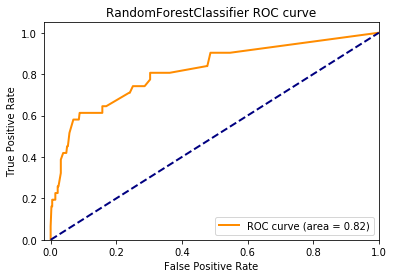

lbr_score 0.9133333333333333
MSE 0.05333333333333334


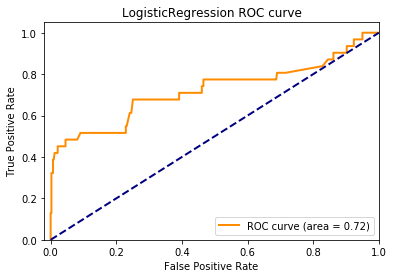

xgb_score 0.9352380952380952
MSE 0.05333333333333334


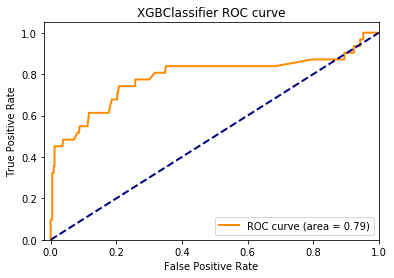

lgbm_score 0.9638095238095238
MSE 0.06444444444444444


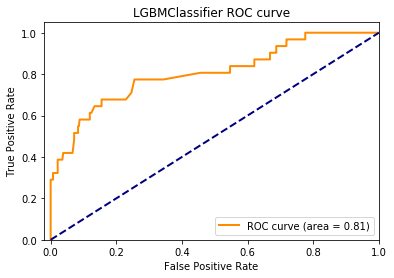

gb_score 0.9495238095238095
MSE 0.05555555555555555


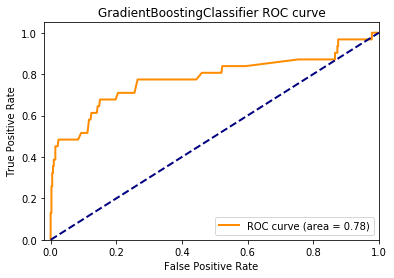

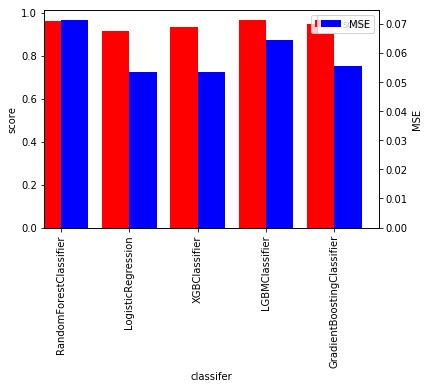

In [105]:
df, no_f1f2_model = train_models(train_df.fillna(0), train_login)
draw_score_MSE(df)

## 두가지 (f1, f2) feature engineering 한 데이터로 학습함

rf_score 0.9619047619047619
MSE 0.06888888888888889


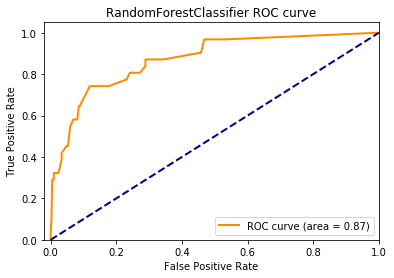

lbr_score 0.9123809523809524
MSE 0.04888888888888889


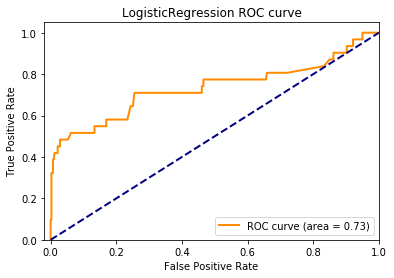

xgb_score 0.9352380952380952
MSE 0.04666666666666667


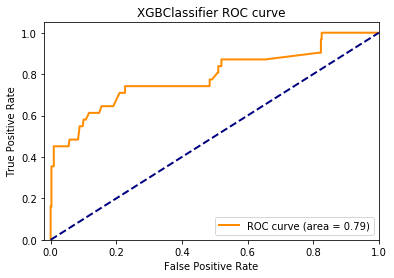

lgbm_score 0.9628571428571429
MSE 0.06666666666666667


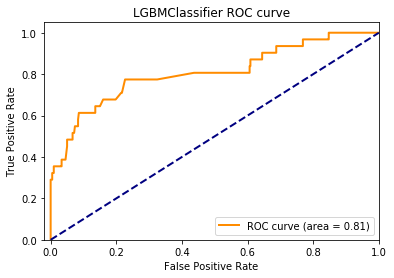

gb_score 0.9514285714285714
MSE 0.057777777777777775


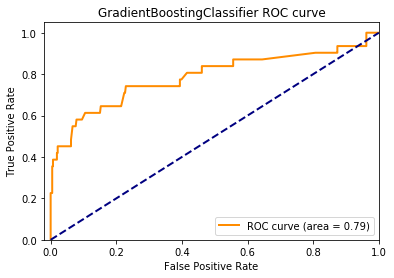

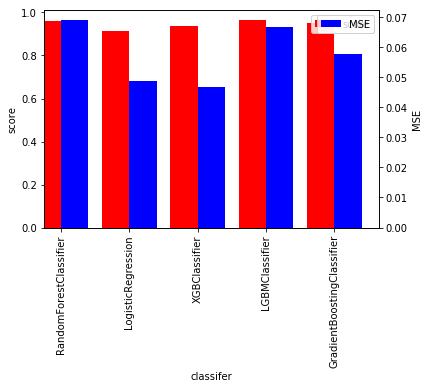

In [106]:
df, f1f2_model = train_models(train_f1f2_df, train_login)
draw_score_MSE(df)

## NA 컬럼 복구하고, 두가지 (f1, f2) feature engineering 한 데이터로 학습함

rf_score 0.960952380952381
MSE 0.06888888888888889


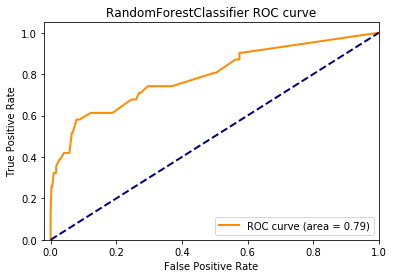

lbr_score 0.9133333333333333
MSE 0.05555555555555555


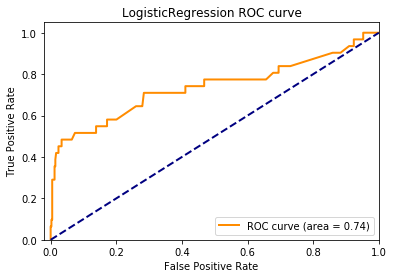

xgb_score 0.940952380952381
MSE 0.051111111111111114


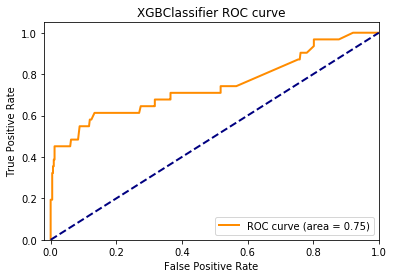

lgbm_score 0.959047619047619
MSE 0.06666666666666667


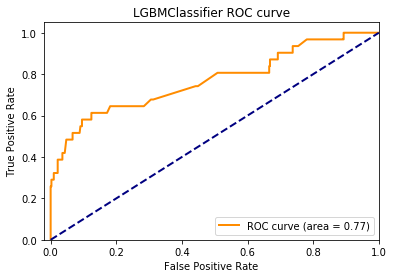

gb_score 0.9523809523809523
MSE 0.06


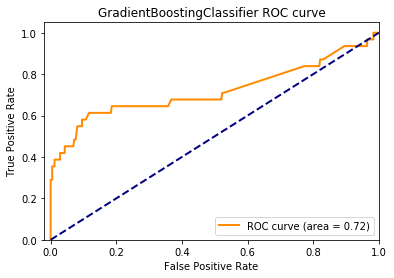

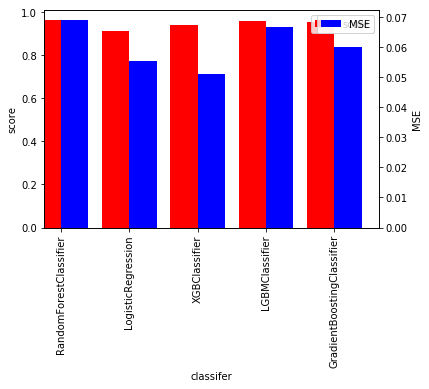

In [107]:
df, NAf1f2_model = train_models(train_f1f2_recover_NaN_df, train_login)
draw_score_MSE(df)

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

N/A

## 6. 결과 및 결언
## Conclusion & Discussion


- 아래 3가지 데이터셋으로 학습해본 결과, 2번의 auc 값이 가장 높음
 1. feature engineering 하지 않은 데이터 학습
 2. 두가지 (f1, f2) feature engineering 한 데이터로 학습함
 3. NA 컬럼 복구하고, 두가지 (f1, f2) feature engineering 한 데이터로 학습함
- correlation이 어느정도 있는 데이터로 학습을 하여, NA 컬럼을 복구해야지, 관계가 없는 Sex, email_type등으로 학습시켜 복구 해봤지만, 결과는 더 안좋음

In [118]:
train_f1f2_df.head()

,Sex,email_type,past_login_total,past_1_month_login,past_1_week_login,phone_rat,desktop_rat,sub_size,recent_1_week_login_rate,login_trend,login_trend_week18
0,Unknown,gmail,2.0,0.0,0.0,1.000000,0.000000,0.0,0.00,0.005358,0.084003
1,Unknown,naver,7.0,0.0,0.0,0.000000,1.000000,0.0,0.00,0.018752,0.294011
2,Unknown,gmail,73.0,0.0,0.0,0.082192,0.917808,39.0,0.00,0.195561,3.066112
3,Unknown,naver,22.0,2.0,0.0,0.000000,1.000000,21.0,0.00,0.075888,1.234795
4,Unknown,gmail,21.0,19.0,18.0,0.000000,1.000000,49.0,0.45,0.492594,9.174229


In [120]:
test_f1f2_df.head()

,Sex,email_type,past_login_total,past_1_month_login,past_1_week_login,phone_rat,desktop_rat,sub_size,recent_1_week_login_rate,login_trend,login_trend_week18
0,male,naver,14.0,0.0,0.0,0.5,0.5,0.0,0.0,0.037505,0.588021
1,male,gmail,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.000000,0.000000
2,female,naver,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.002679,0.042002
3,Unknown,daik.com,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.000000,0.000000
4,Unknown,gmail,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.011155,0.197382


In [121]:
model = f1f2_model['model'][0]

In [122]:
y_pred_test = model.predict_proba(pd.get_dummies(test_f1f2_df))
y_pred_test = y_pred_test[:,1]

person_id = list(test_person_id)
person_id[:10]

submission_df = pd.DataFrame()
submission_df['person_id'] = person_id
submission_df['login'] = y_pred_test
submission_df.head()

submission_df.to_csv('1009-last.csv', index = False)